In [1]:
#%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

## Sub-daily data

Prophet can make forecasts for time series with sub-daily observations by passing in a dataframe with timestamps in the `ds` column. The format of the timestamps should be YYYY-MM-DD HH:MM:SS - see the example csv [here](https://github.com/facebook/prophet/blob/master/examples/example_yosemite_temps.csv). When sub-daily data are used, daily seasonality will automatically be fit. Here we fit Prophet to data with 5-minute resolution (daily temperatures at Yosemite):

日別でないデータも扱うことができる。例として、ヨセミテの5分ごとの気温の変化を予測してみる。
データ形式は、日付を表す`YYYY-MM-DD`の後に時刻を表す`HH:MM:SS`を追加する。

未来の時刻を表すデータフレームは、make_future_dataframeで生成するが、このとき引数freqで時間の刻みを指定する。
ここでは1時間を表す'H'を指定する。


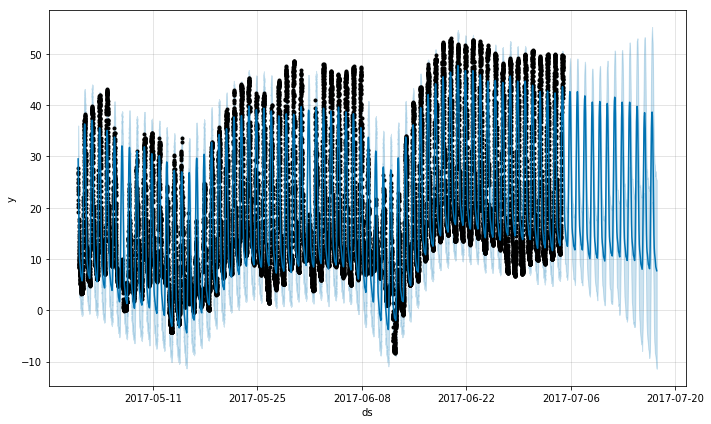

In [9]:
df = pd.read_csv('../examples/example_yosemite_temps.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

In [10]:
df.head()

,ds,y
0,2017-05-01 00:00:00,27.8
1,2017-05-01 00:05:00,27.0
2,2017-05-01 00:10:00,26.8
3,2017-05-01 00:15:00,26.5
4,2017-05-01 00:20:00,25.6


In [13]:
#m.make_future_dataframe??
pd.date_range?

The daily seasonality will show up in the components plot:

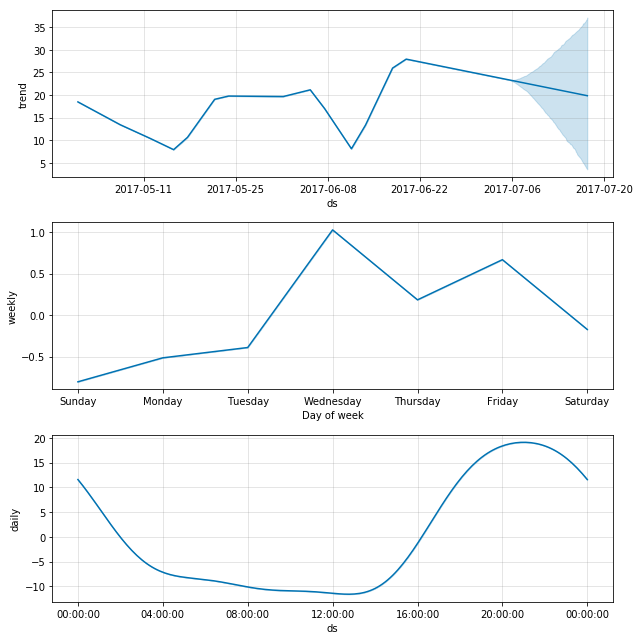

In [3]:
fig = m.plot_components(fcst)

## Data with regular gaps

Suppose the dataset above only had observations from 12a to 6a:

時刻が０時から６時までの間しか観測できなかったと仮定して予測してみる。

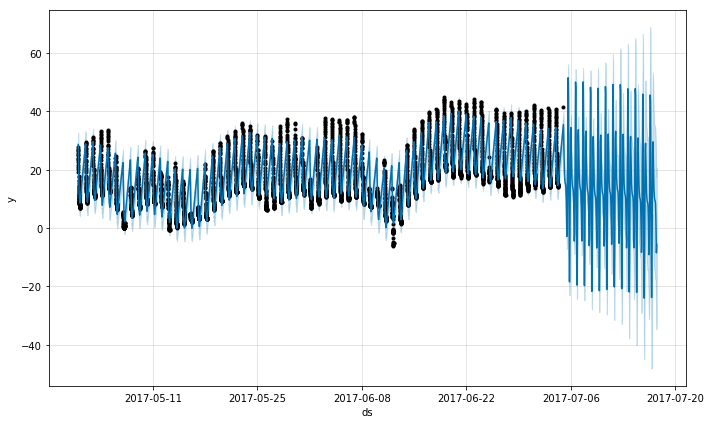

In [4]:
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2[df2['ds'].dt.hour < 6]
m = Prophet().fit(df2)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

The forecast seems quite poor, with much larger fluctuations in the future than were seen in the history. The issue here is that we have fit a daily cycle to a time series that only has data for part of the day (12a to 6a). The daily seasonality is thus unconstrained for the remainder of the day and is not estimated well. The solution is to only make predictions for the time windows for which there are historical data. Here, that means to limit the `future` dataframe to have times from 12a to 6a:

予測幅が大きくなってしまった。未来の時刻も６時前のものにして予測してみる。

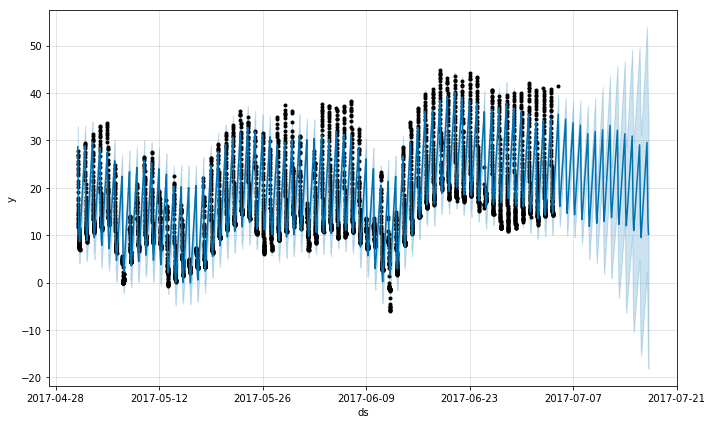

In [5]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6]
fcst = m.predict(future2)
fig = m.plot(fcst)

The same principle applies to other datasets with regular gaps in the data. For example, if the history contains only weekdays, then predictions should only be made for weekdays since the weekly seasonality will not be well estimated for the weekends.

## Monthly data

You can use Prophet to fit monthly data. However, the underlying model is continuous-time, which means that you can get strange results if you fit the model to monthly data and then ask for daily forecasts. Here we forecast US retail sales volume for the next 10 years:

米国の小売店の需要の月次データを用いて予測してみる。このデータは月の始めにしかデータがない。既定値は日時なので、そのまま予測するとうまくいかない。

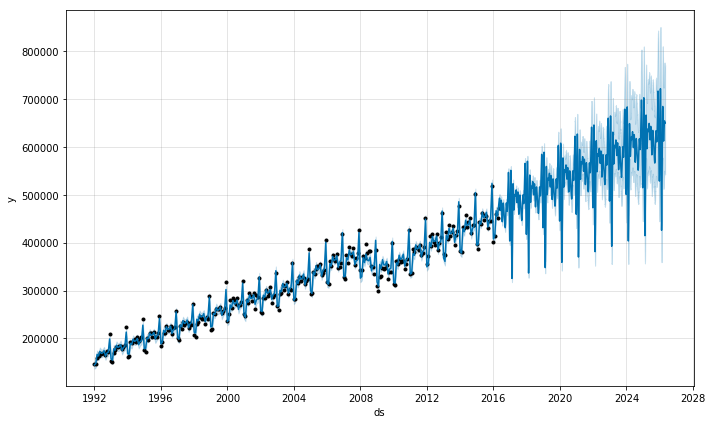

In [14]:
df = pd.read_csv('../examples/example_retail_sales.csv')
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=3652)
fcst = m.predict(future)
fig = m.plot(fcst)

In [16]:
df.head()

,ds,y
0,1992-01-01,146376
1,1992-02-01,147079
2,1992-03-01,159336
3,1992-04-01,163669
4,1992-05-01,170068


This is the same issue from above where the dataset has regular gaps. When we fit the yearly seasonality, it only has data for the first of each month and the seasonality components for the remaining days are unidentifiable and overfit. This can be clearly seen by doing MCMC to see uncertainty in the seasonality:

季節変動を加味して、マルコフ連鎖モンテカルロ法で季節変動の不確実性も予測してみる。以下のように、月初は合っているが、月の途中で誤差が大きくなっていることが確認できる。

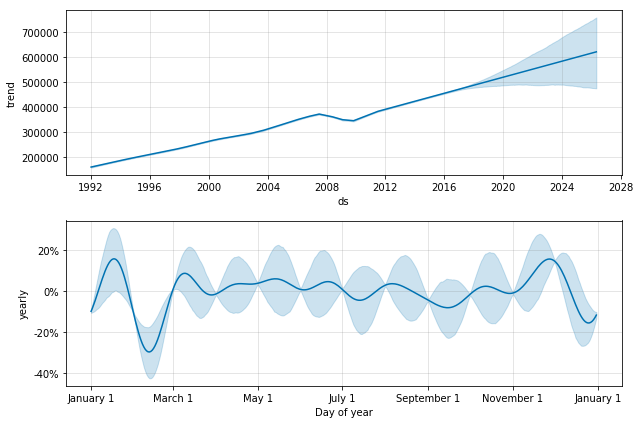

In [7]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(df)
fcst = m.predict(future)
fig = m.plot_components(fcst)

The seasonality has low uncertainty at the start of each month where there are data points, but has very high posterior variance in between. When fitting Prophet to monthly data, only make monthly forecasts, which can be done by passing the frequency into `make_future_dataframe`:

未来の日時を生成する際に、月次で生成するとうまく予測できる。

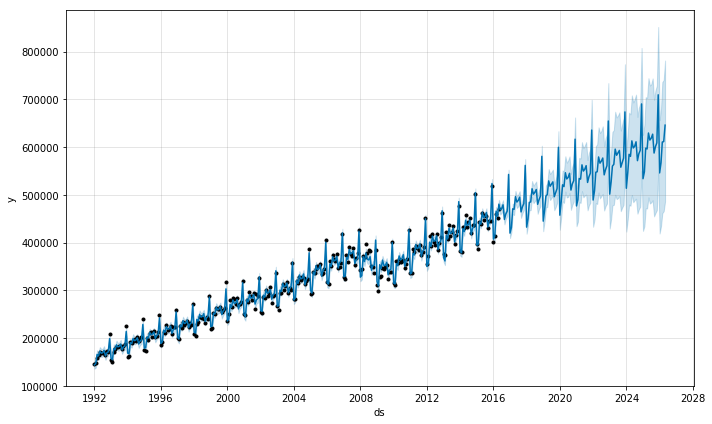

In [8]:
future = m.make_future_dataframe(periods=120, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)